# CDades Proyecte Final.
## Análisis de datos y Machine Learning aplicados a la gestión del e-commerce.

## **Índice**   
### 1. [Librerías](#id1)
### 2. [Preparación de nuestros datos](#id2)
### 3. [Análisis exploratorio de los datos, EDA](#id3)
### 4. [Segmentación de los clientes (Customer segmentation)](#id4)
### 5. [Valor de la vida de un cliente, CLV (Customer Lifetime Value)](#id5)
### 6. [Predicción de tasa de abandono (Churn Prediction)](#id6)
### 7. [Predicción de ventas (Sales forecasting)](#id7)

## Librerías.<a name="id1"></a>

In [1]:
import numpy as np
import pandas as pd
from pandas import Timestamp
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime as dt
from datetime import datetime
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, f1_score
import lifetimes
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Preparación de nuestros datos.<a name="id2"></a>

#### Dataset clientes.

In [2]:
df_customer = pd.read_csv("C:/IT Academy/Proyecto IT Academy/brazilian e-commerce dataset/olist_customers_dataset.csv", sep=',')

In [3]:
df_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Datos que encontramos en este dataset:
- customer_id, clave única que une con el dataset de pedidos, olist_orders_dataset.csv, cada pedido tiene una clave única
- customer_unique_id, identificador único de cada cliente
- customer_zip_code_prefix, primeros cinco dígitos del código postal del cliente
- customer_city, nombre de la ciudad del cliente
- customer_state, nombre del estado del cliente

In [4]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Dataset con 99441 registros y cinco variables, cuatro de texto y una numérica. No hay valores vacíos ni nulos.

#### Dataset de los productos vendidos.

In [5]:
df_order_items = pd.read_csv("C:/IT Academy/Proyecto IT Academy/brazilian e-commerce dataset/olist_order_items_dataset.csv", sep=',')

In [6]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Datos que encontramos en este dataset:
- order_id, identificador único de cada pedido
- order_item_id, identificador único del número de productos incluido en el mismo pedido
- product_id, identificador único de cada producto
- seller_id, identificador único de cada vendedor
- shipping_limit_day, fecha límite para que el vendedor entregue el pedido al transportista
- price, precio del producto
- freight_value, precio del transporte de cada producto, si hay más de un producto en el pedido se reparte el coste

In [7]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Dataset con 112650 registros y siete variables, cuatro de texto (una es temporal) y tres numéricas. No hay valores vacíos ni nulos.

#### Dataset de los pedidos realizados.

In [8]:
df_orders = pd.read_csv("C:/IT Academy/Proyecto IT Academy/brazilian e-commerce dataset/olist_orders_dataset.csv", sep=',')

In [9]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Datos que encontramos en este dataset:
- order_id, identificador único de cada pedido
- customer_id, clave única que une con el dataset de pedidos, olist_orders_dataset.csv, cada pedido tiene una clave única
- order_status, estado del pedido, enviado, entregado...
- order_purchase_timestamp, fecha y hora a la que se hizo el pedido
- order_approved_at, fecha y hora a la que que se aprovó el pago del pedido
- order_delivered_carrier_date, fecha y hora a la que el vendedor entregó el pedido al transporte
- order_delivered_customer_date, fecha y hora a la que el pedido se entregó al cliente
- order_estimated_customer_date, fecha y hora de entrega estimada que se le da al cliente cuando hace la compra

In [10]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Dataset con 99441 registros y ocho variables, todas de texto, cuatro de ellas temporales. Vemos valores vacíos en order_approved_at, order_delivered_carrier_date y order_delivered_customer_date.

Unimos los datasets de pedidos y productos vendidos.

In [11]:
df_orders_items_customers = pd.merge(df_orders, df_order_items, on='order_id', how='outer')

Unimos el dataset anterior con el dataset de clientes.

In [12]:
df_orders_items_customers = pd.merge(df_orders_items_customers, df_customer, on='customer_id', how='outer')

In [13]:
df_orders_items_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [14]:
del df_customer, df_orders, df_order_items  # borramos los tres datasets iniciales

Eliminamos variables de nuestro dataset que no necesitamos para nuestro proyecto.

In [15]:
df_orders_items_customers = df_orders_items_customers.drop(['customer_id', 'seller_id','order_delivered_carrier_date','product_id','order_delivered_customer_date','order_estimated_delivery_date','order_approved_at','shipping_limit_date','freight_value','customer_zip_code_prefix','customer_city','customer_state'], axis=1)

#### Ya tenemos el dataset con el que vamos a trabajar.

In [16]:
df_orders_items_customers.head()

,order_id,order_status,order_purchase_timestamp,order_item_id,price,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,1.0,29.99,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,1.0,118.70,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,1.0,159.90,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,1.0,45.00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,1.0,19.90,72632f0f9dd73dfee390c9b22eb56dd6


## Análisis exploratorio de los datos, EDA.<a name="id3"></a>

Análisis preliminar.

In [17]:
df_orders_items_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  113425 non-null  object 
 1   order_status              113425 non-null  object 
 2   order_purchase_timestamp  113425 non-null  object 
 3   order_item_id             112650 non-null  float64
 4   price                     112650 non-null  float64
 5   customer_unique_id        113425 non-null  object 
dtypes: float64(2), object(4)
memory usage: 6.1+ MB


Dataset con 113425 registros y seis variables, cuatro de texto, una de ellas temporal, y dos numéricas. Vemos valores vacíos en order_iten_id y price, registros que hacen referencia a los artículos.

In [18]:
df_orders_items_customers.describe()

,order_item_id,price
count,112650.000000,112650.000000
mean,1.197834,120.653739
std,0.705124,183.633928
min,1.000000,0.850000
25%,1.000000,39.900000
50%,1.000000,74.990000
75%,1.000000,134.900000
max,21.000000,6735.000000


#### Obtenemos información de los pedidos con esta primera aproximación a los datos:  
- La media de artículos comprados es de 1.19 artículos, el máximo número en una compra es de 23 artículos. Vamos que más del 75% de las compras son de un sólo artículo.
- El precio medio de los artículos es de 120.65R$, la moneda de este dataset son los reales brasileños. Sin embargo la distribución del precio está desviada a la derecha, hay casi un 25\% de los artículos que están por encima de esta media, como podemos corroborar viendo una desviación estándart alta.

Transformamos la variables que contiene fechas a variable temporal.

In [19]:
df_orders_items_customers['order_purchase_timestamp'] = pd.to_datetime(df_orders_items_customers['order_purchase_timestamp'])

In [20]:
df_orders_items_customers.dtypes

order_id                            object
order_status                        object
order_purchase_timestamp    datetime64[ns]
order_item_id                      float64
price                              float64
customer_unique_id                  object
dtype: object

Creamos una variable temporal nueva sólo con la fecha.

In [21]:
df_orders_items_customers['order_purchase_date'] = df_orders_items_customers['order_purchase_timestamp'].dt.date
df_orders_items_customers['order_purchase_date'] = pd.to_datetime(df_orders_items_customers['order_purchase_date'])

In [22]:
df_orders_items_customers.head()

,order_id,order_status,order_purchase_timestamp,order_item_id,price,customer_unique_id,order_purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,1.0,29.99,7c396fd4830fd04220f754e42b4e5bff,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,1.0,118.70,af07308b275d755c9edb36a90c618231,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,1.0,159.90,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,1.0,45.00,7c142cf63193a1473d2e66489a9ae977,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,1.0,19.90,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13


In [23]:
df_orders_items_customers.dtypes

order_id                            object
order_status                        object
order_purchase_timestamp    datetime64[ns]
order_item_id                      float64
price                              float64
customer_unique_id                  object
order_purchase_date         datetime64[ns]
dtype: object

Eliminamos la variables temporal inicial.

In [24]:
df_orders_items_customers = df_orders_items_customers.drop(['order_purchase_timestamp'], axis=1)

Vemos si hay valores vacíos.

In [25]:
df_orders_items_customers.isna().sum()

order_id                 0
order_status             0
order_item_id          775
price                  775
customer_unique_id       0
order_purchase_date      0
dtype: int64

In [26]:
df_orders_items_customers.sort_values('order_item_id', na_position='first').head()

,order_id,order_status,order_item_id,price,customer_unique_id,order_purchase_date
306,8e24261a7e58791d10cb1bf9da94df5c,unavailable,NaN,NaN,41fc647b8c6bd979b1b6364b60471b50,2017-11-16
671,c272bcd21c287498b4883c7512019702,unavailable,NaN,NaN,0e634b16e4c585acbd7b2e8276ce6677,2018-01-31
791,37553832a3a89c9b2db59701c357ca67,unavailable,NaN,NaN,596ed6d7a35890b3fbac54ec01f69685,2017-08-14
850,d57e15fb07fd180f06ab3926b39edcd2,unavailable,NaN,NaN,2349bbb558908e0955e98d47dacb7adb,2018-01-08
1294,00b1cb0320190ca0daa2c88b35206009,canceled,NaN,NaN,4fa4365000c7090fcb8cad5713c6d3db,2018-08-28


Vemos que los valores vacíos son datos identificativos de productos incluídos en pedidos, su referencia y su precio, como vimos al principio. No podemos sustituir estos valores y los eliminamos. No afectará a nuestro resultado por la naturaleza del dato y por representar menos de 1% del conjunto.

In [27]:
df_orders_items_customers = df_orders_items_customers.dropna().reset_index(drop=True)

Comprobamos que ya no tenemos valores vacíos.

In [28]:
df_orders_items_customers.isna().sum()

order_id               0
order_status           0
order_item_id          0
price                  0
customer_unique_id     0
order_purchase_date    0
dtype: int64

Comprobamos que no tenemos valores nulos.

In [29]:
df_orders_items_customers.isnull().sum()

order_id               0
order_status           0
order_item_id          0
price                  0
customer_unique_id     0
order_purchase_date    0
dtype: int64

Status de los pedidos.

In [30]:
df_orders_items_customers.order_status.nunique()

7

In [31]:
df_orders_items_customers.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'canceled',
       'unavailable', 'approved'], dtype=object)

Tenemos siete posibles estados en los pedidos, vemos cuántos pedidos están en cada uno.

In [32]:
order_status = ['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved']

In [33]:
for status in order_status:
    print(df_orders_items_customers[df_orders_items_customers['order_status']== status]['order_status'].value_counts())

delivered    110197
Name: order_status, dtype: int64
invoiced    359
Name: order_status, dtype: int64
shipped    1185
Name: order_status, dtype: int64
processing    357
Name: order_status, dtype: int64
unavailable    7
Name: order_status, dtype: int64
canceled    542
Name: order_status, dtype: int64
Series([], Name: order_status, dtype: int64)
approved    3
Name: order_status, dtype: int64


Eliminamos los pedidos cancelados y erróneos.

In [34]:
df_orders_items_customers = df_orders_items_customers.where(df_orders_items_customers['order_status']!=('canceled'))
df_orders_items_customers = df_orders_items_customers.where(df_orders_items_customers['order_status']!=('unavailable'))

In [35]:
df_orders_items_customers.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', nan, 'approved'],
      dtype=object)

Vemos que tenemos el status Nan, de los valores eliminados.

In [36]:
df_orders_items_customers.isna().sum()

order_id               549
order_status           549
order_item_id          549
price                  549
customer_unique_id     549
order_purchase_date    549
dtype: int64

Eliminamos los registros vacíos.

In [37]:
df_orders_items_customers = df_orders_items_customers.dropna().reset_index(drop=True)

Vemos si hay pedidos duplicados.

In [38]:
df_orders_items_customers.duplicated('order_id').sum()

13902

In [39]:
df_orders_items_customers.sort_values('order_id').head(20)

,order_id,order_status,order_item_id,price,customer_unique_id,order_purchase_date
95995,00010242fe8c5a6d1ba2dd792cb16214,delivered,1.0,58.90,871766c5855e863f6eccc05f988b23cb,2017-09-13
80948,00018f77f2f0320c557190d7a144bdd3,delivered,1.0,239.90,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26
7056,000229ec398224ef6ca0657da4fc703e,delivered,1.0,199.00,3818d81c6709e39d06b2738a8d3a2474,2018-01-14
25364,00024acbcdf0a6daa1e931b038114c75,delivered,1.0,12.99,af861d436cfc08b2c2ddefd0ba074622,2018-08-08
5867,00042b26cf59d7ce69dfabb4e55b4fd9,delivered,1.0,199.90,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04
78233,00048cc3ae777c65dbb7d2a0634bc1ea,delivered,1.0,21.90,85c835d128beae5b4ce8602c491bf385,2017-05-15
111094,00054e8431b9d7675808bcb819fb4a32,delivered,1.0,19.90,635d9ac1680f03288e72ada3a1035803,2017-12-10
53256,000576fe39319847cbb9d288c5617fa6,delivered,1.0,810.00,fda4476abb6307ab3c415b7e6d026526,2018-07-04
103875,0005a1a1728c9d785b8e2b08b904576c,delivered,1.0,145.95,639d23421f5517f69d0c3d6e6564cf0e,2018-03-19
93695,0005f50442cb953dcd1d21e1fb923495,delivered,1.0,53.99,0782c41380992a5a533489063df0eef6,2018-07-02


Analizamos el pedido '0008288aa423d2a3f00fcb17cd7d8719'.

In [40]:
df_orders_items_customers[df_orders_items_customers['order_id']=='0008288aa423d2a3f00fcb17cd7d8719']

,order_id,order_status,order_item_id,price,customer_unique_id,order_purchase_date
60771,0008288aa423d2a3f00fcb17cd7d8719,delivered,1.0,49.9,9e4159995424971423b98c4a8bc11529,2018-02-13
60772,0008288aa423d2a3f00fcb17cd7d8719,delivered,2.0,49.9,9e4159995424971423b98c4a8bc11529,2018-02-13


La variable 'order_item_id' representa el número de artículos que hay en un pedido. Al ser un marketplace hay varios vendedores y un mismo pedido puede tener el mismo identidicador 'order_id', misma fecha 'order_purchase_date', mismo estado de entrega 'order_status', mismo cliente 'customer_unique_id' y mismo total 'price' y tener un registro por cada artículo, como vemos arriba.

Este es el motivo por el que tenemos pedidos duplicados. En nuestro proyecto no vamos a trabajar con los artículos ni con sus vendedores, es suficiente tener un registro por pedido independientemente del artículo que contenga. Filtraremos los pedidos quedándonos con el primer artículo, así no perdemos ningún pedido, tengan un artículo en la compra o varios.  
Nombramos nuestro dataset con un 1 para tener presente este filtro.

In [41]:
df_orders_items_customers_1 = df_orders_items_customers.where(df_orders_items_customers['order_item_id'] == 1)

Comprobamos que no tenemos duplicados.

In [42]:
df_orders_items_customers_1.duplicated('order_id').sum()

13901

In [43]:
df_orders_items_customers_1.head(20)

,order_id,order_status,order_item_id,price,customer_unique_id,order_purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,1.0,29.99,7c396fd4830fd04220f754e42b4e5bff,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,1.0,118.70,af07308b275d755c9edb36a90c618231,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,1.0,159.90,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,1.0,45.00,7c142cf63193a1473d2e66489a9ae977,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,1.0,19.90,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13
5,a4591c265e18cb1dcee52889e2d8acc3,delivered,1.0,147.90,80bb27c7c16e8f973207a5086ab329e2,2017-07-09
6,136cce7faa42fdb2cefd53fdc79a6098,invoiced,1.0,49.90,36edbb3fb164b1f16485364b6fb04c73,2017-04-11
7,6514b8ad8028c9f2cc2374ded245783f,delivered,1.0,59.99,932afa1e708222e5821dac9cd5db4cae,2017-05-16
8,76c6e866289321a7c93b82b54852dc33,delivered,1.0,19.90,39382392765b6dc74812866ee5ee92a7,2017-01-23
9,e69bfb5eb88e0ed6a785585b27e16dbf,delivered,1.0,149.99,299905e3934e9e181bfb2e164dd4b4f8,2017-07-29


Vemos que los duplicados son los vacíos de haber eliminado pedidos duplicados.

In [44]:
df_orders_items_customers_1.isna().sum()

order_id               13902
order_status           13902
order_item_id          13902
price                  13902
customer_unique_id     13902
order_purchase_date    13902
dtype: int64

Eliminamos los registros vacíos.

In [45]:
df_orders_items_customers_1 = df_orders_items_customers_1.dropna().reset_index(drop=True)

In [46]:
df_orders_items_customers_1.duplicated('order_id').sum()

0

Ahora que sabemos que el estado del pedido no duplica los pedidos, y como no necesitamos este dato en este proyecto, lo eliminamos.

In [47]:
df_orders_items_customers_1 = df_orders_items_customers_1.drop(['order_status'], axis=1)

Ya tenemos el dataset preparado.

In [48]:
df_orders_items_customers_1.head()

,order_id,order_item_id,price,customer_unique_id,order_purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,29.99,7c396fd4830fd04220f754e42b4e5bff,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,118.70,af07308b275d755c9edb36a90c618231,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,159.90,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,45.00,7c142cf63193a1473d2e66489a9ae977,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,19.90,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13


Eliminamos el dataset anterior df_orders_items_customers para liberar memoria.

In [49]:
del df_orders_items_customers

In [50]:
df_orders_items_customers_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98199 entries, 0 to 98198
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   order_id             98199 non-null  object        
 1   order_item_id        98199 non-null  float64       
 2   price                98199 non-null  float64       
 3   customer_unique_id   98199 non-null  object        
 4   order_purchase_date  98199 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 3.7+ MB


#### El número real de pedidos, 98199, sin duplicados ni pedidos cancelados. Podemos ahora decir que los 579 pedidos cancelados o erróneos, calculados anteriormente, representan sólo un 0,5%.

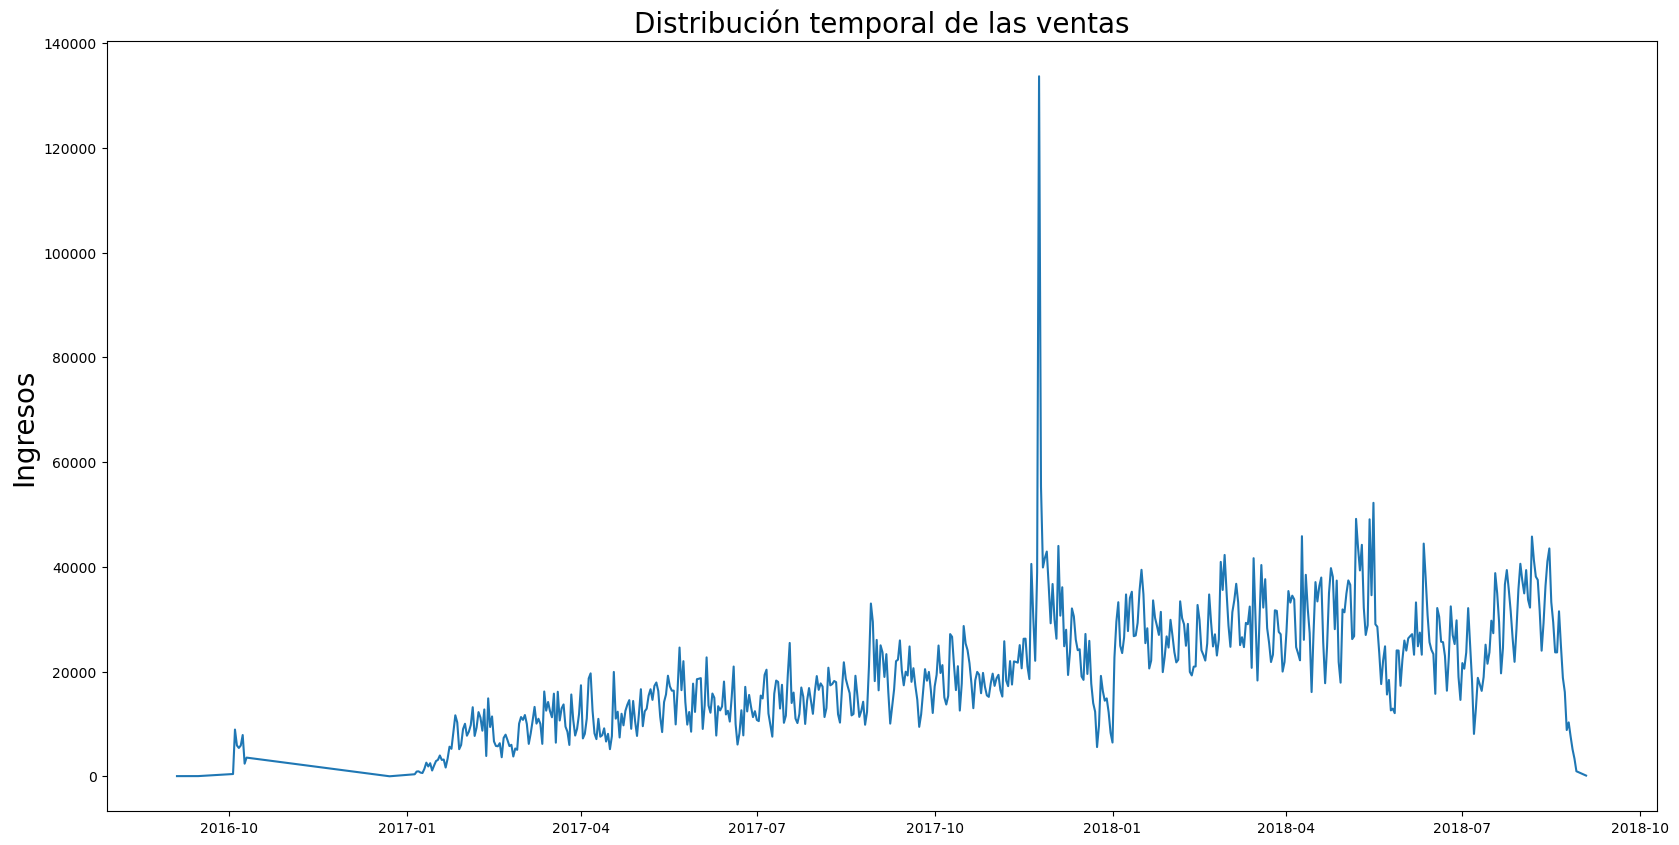

In [51]:
sales = df_orders_items_customers_1.groupby('order_purchase_date')['price'].sum()
plt.figure(figsize=(20, 10))
plt.title('Distribución temporal de las ventas',fontsize = 20)
plt.ylabel('Ingresos',fontsize = 20)
plt.plot(sales)
plt.savefig('sales.png');

In [52]:
plt.close()

In [53]:
df_orders_items_customers_1.order_purchase_date.max()

Timestamp('2018-09-03 00:00:00')

In [54]:
df_orders_items_customers_1.order_purchase_date.min()

Timestamp('2016-09-04 00:00:00')

La serie temporal del dataset empieza el 04/09/2016 y acaba el 03-09-2018. Vemos que en septiembre, noviembre y diciembre de 2016 no se apecian ventas, tampoco en septiembre de 2018. Hay picos de venta marcados que corresponden a Pascua, 09-04, Día de la madre 2018, 13-05 y Black Friday 2017, 24-11.

## Segmentación de los clientes (Customer segmentation).<a name="id4"></a>

Número de clientes.

In [55]:
df_orders_items_customers_1.customer_unique_id.nunique()

94983

Número de pedidos.

In [56]:
df_orders_items_customers_1.order_id.nunique()

98199

Podemos ver que hay clientes recurrentes que han hecho más de un pedido.

Número de pedidos de clientes que han hecho más de un pedido.

In [57]:
df_orders_items_customers_1.duplicated('customer_unique_id').sum()

3216

#### Vemos 3216 pedidos de clientes recurrentes, lo que representa solo un 3,2% del total.

#### Segmentación RFM de los clientes.

Agrupamos los pedidos de cada cliente y calculamos la fecha de su última compra.

In [58]:
df_customers_CLV = df_orders_items_customers_1.groupby('customer_unique_id').order_purchase_date.max().reset_index()

In [59]:
df_customers_CLV.head()

,customer_unique_id,order_purchase_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07
2,0000f46a3911fa3c0805444483337064,2017-03-10
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14


Calculamos el Recency de cada cliente, días desde la última compra de un cliente hasta el día de la segmentación, que o tomamos como el último día de registro del dataset.

In [60]:
df_RFM = pd.DataFrame(columns=('customer_unique_id','Recency'))
df_RFM['customer_unique_id'] = df_customers_CLV['customer_unique_id']
df_RFM['Recency'] = (df_customers_CLV.order_purchase_date.max()-df_customers_CLV.order_purchase_date).dt.days

In [61]:
df_RFM.head()

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119
2,0000f46a3911fa3c0805444483337064,542
3,0000f6ccb0745a6a4b88665a16c9f078,326
4,0004aac84e0df4da2b147fca70cf8255,293


Nos apoyamos en un dataframe temporal.

In [62]:
df_RFM_temp= df_orders_items_customers_1.groupby('customer_unique_id').sum('order_item_id').sort_values('order_item_id', ascending=False).reset_index()

In [63]:
df_RFM_temp.head()

,customer_unique_id,order_item_id,price
0,8d50f5eadf50201ccdcedfb9e2ac8455,16.0,729.62
1,3e43e6105506432c953e165fb2acf44c,9.0,800.15
2,ca77025e7201e3b30c44b472ff346268,7.0,666.66
3,6469f99c1f9dfae7733b25662e7f1782,7.0,614.40
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7.0,621.22


Calculamos el Frequency de cada cliente, número de compras, y el Monetary, gasto total de los clientes en el marketplace.

In [64]:
df_RFM = pd.merge(df_RFM, df_RFM_temp, on='customer_unique_id', how='outer')
df_RFM.rename(columns={'order_item_id': 'Frequency',
                   'price': 'Monetary'},
          inplace=True, errors='raise')

In [65]:
df_RFM.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1.0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1.0,18.90
2,0000f46a3911fa3c0805444483337064,542,1.0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1.0,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1.0,180.00


In [66]:
del df_RFM_temp

In [67]:
df_RFM.describe()

,Recency,Frequency,Monetary
count,94983.000000,94983.000000,94983.000000
mean,243.334197,1.033859,129.941771
std,152.984601,0.210811,196.077854
min,0.000000,1.000000,0.850000
25%,119.000000,1.000000,43.890000
50%,224.000000,1.000000,79.900000
75%,352.000000,1.000000,144.900000
max,729.000000,16.000000,7388.000000


#### Visualización de la distribución de Recency, Frequency y Monetary.

<Figure size 2000x2000 with 0 Axes>

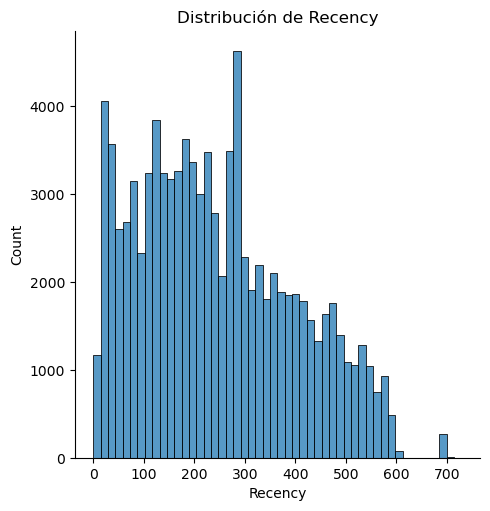

In [68]:
plt.figure(figsize=(20, 20))
sns.displot(df_RFM, x='Recency', bins=50)
plt.title('Distribución de Recency', fontsize=12);
plt.savefig("Recency.png");

In [69]:
df_RFM.groupby('Recency').customer_unique_id.count()

Recency
0       1
5      11
6      39
7      66
8      73
       ..
698    37
699    57
700     6
718     1
729     1
Name: customer_unique_id, Length: 613, dtype: int64

La distribución de Recency es bimodal no gausiana y nos da información sobre la retención de los que clientes que hay en este marketplace. Un 25% de los clientes, aproximadamente, llevan más de un año sin comprar, más del 25% lleva tres meses. La media es de 243 días.

<Figure size 2000x1000 with 0 Axes>

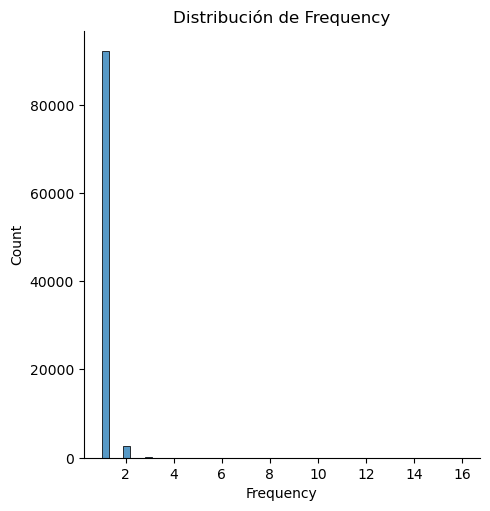

In [70]:
plt.figure(figsize=(20, 10))
sns.displot(df_RFM, x='Frequency', bins=50)
plt.title('Distribución de Frequency', fontsize=12)
plt.savefig("Frequency.png");

In [71]:
df_RFM.groupby('Frequency').customer_unique_id.count()

Frequency
1.0     92096
2.0      2651
3.0       188
4.0        29
5.0         9
6.0         5
7.0         3
9.0         1
16.0        1
Name: customer_unique_id, dtype: int64

Confirmamos con la distribución de Frequency que sólo un 3% de los clientes es recurrente, y de ellos la mayoría hace 3 compras o menos.

<Figure size 2000x1000 with 0 Axes>

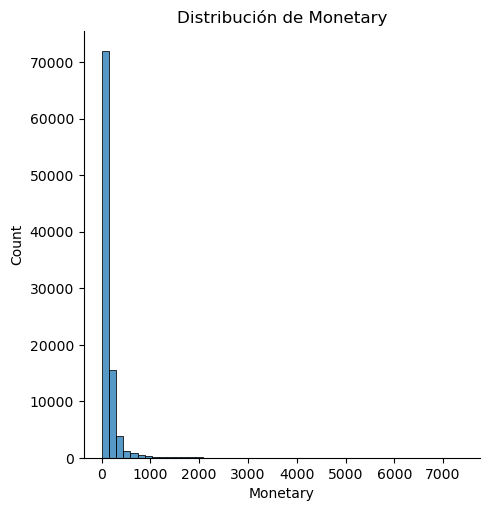

In [72]:
plt.figure(figsize=(20, 10))
sns.displot(df_RFM, x="Monetary", bins=50)
plt.title('Distribución de Monetary', fontsize=12)
plt.savefig("Monetary.png");

In [73]:
df_RFM.sort_values('Monetary', ascending=True).head(10)

,customer_unique_id,Recency,Frequency,Monetary
66698,b38211bd797f4fdd81a98b9d1754b606,132,1.0,0.85
80262,d80730c15c647bc8f2ad77c908ba5ca9,132,1.0,0.85
25771,4546caea018ad8c692964e3382debd19,414,1.0,1.20
18435,317cfc692e3f86c45c95697c61c853a6,9,1.0,2.20
70229,bd06ce0e06ad77a7f681f1a4960a3cc6,355,1.0,2.29
76941,cf3839da0d9492ad151690b65f45d800,213,1.0,2.99
25648,44eba5de8af60ec8b057ab4983f0868a,62,1.0,3.00
40704,6d6065917074c293416673faaba09336,24,1.0,3.00
71780,c11707e79810c13fddeade78050d3a05,48,1.0,3.06
66604,b33336f46234b24a613ad9064d13106d,74,1.0,3.50


In [74]:
df_RFM.sort_values('Monetary', ascending=False).head(10)

,customer_unique_id,Recency,Frequency,Monetary
81011,da122df9eeddfedc1dc1f5349a1a690c,520,2.0,7388.00
81850,dc4802a71eae9be1dd28f5d788ceb526,568,1.0,6735.00
25901,459bef486812aa25204be022145caa62,40,1.0,6729.00
94696,ff4159b92c40ebe40454e3e6a7c35ed6,467,1.0,6499.00
88651,eebb5dda148d3893cdaf5b5ca3040ccb,503,1.0,4690.00
27124,48e1ac109decbb87765a3eade6854098,73,1.0,4590.00
88353,edde2314c6c30e864a128ac95d6b2112,31,1.0,4399.87
92914,fa562ef24d41361e476e748681810e1e,158,1.0,4099.99
75108,ca27f3dac28fb1063faddd424c9d95fa,36,1.0,4059.00
422,011875f0176909c5cf0b14a9138bb691,534,1.0,3999.90


El gasto medio por cliente es de 129 reales brasileños. A pesar de eso, la desviación standard de la distribución del gasto es muy alta, y sólo el 25\% de los clientes gastan más de 144 reales brasileños. El compa mínima es de 0,85 reales brasileños y la máxima de 7388 reales brasileños.

#### Clusterizamos cada variable por separado.

#### Clusterización Recency.

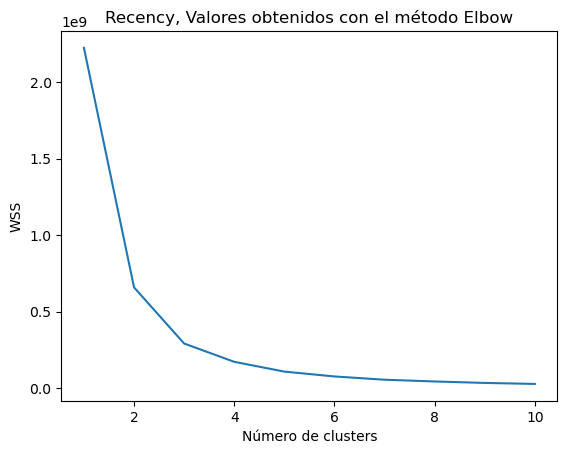

In [75]:
wcss = []  # creamos una lista para almacenar los valores que nos devuelva el modelo con cada grupo de nodos
for i in range(1,11):  # probamos el modelo con con un nodo y vamos aumentando hasta 10 nodos
    kmeans = KMeans(n_clusters=i, random_state= 0)  
    kmeans.fit(df_RFM[['Recency']])  
    wcss.append(kmeans.inertia_)  

plt.plot(range(1, 11), wcss)  
plt.title('Recency, Valores obtenidos con el método Elbow')
plt.xlabel('Número de clusters')  
plt.ylabel('WSS');

In [76]:
Recency_cluster = KMeans(n_clusters=3, random_state=0)
Recency_cluster.fit(df_RFM[['Recency']])

KMeans(n_clusters=3, random_state=0)

In [77]:
Recency_pred = Recency_cluster.fit_predict(df_RFM[['Recency']])
df_RFM['Recency_cluster'] = Recency_pred

In [78]:
df_RFM.groupby('Recency_cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
Recency_cluster,,,,,,,,
0,36495.0,91.977476,49.563763,0.0,45.0,92.0,135.0,175.0
1,22442.0,463.177836,69.096425,362.0,405.0,456.0,514.0,729.0
2,36046.0,259.703074,51.561671,176.0,215.0,262.0,297.0,361.0


In [79]:
df_RFM['Recency_cluster_ord'] = df_RFM['Recency_cluster'].map({0:2, 1:0, 2:1})

In [80]:
df_RFM

,customer_unique_id,Recency,Frequency,Monetary,Recency_cluster,Recency_cluster_ord
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1.0,129.90,0,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1.0,18.90,0,2
2,0000f46a3911fa3c0805444483337064,542,1.0,69.00,1,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1.0,25.99,2,1
4,0004aac84e0df4da2b147fca70cf8255,293,1.0,180.00,2,1
...,...,...,...,...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,452,1.0,890.00,1,0
94979,fffea47cd6d3cc0a88bd621562a9d061,267,1.0,64.89,2,1
94980,ffff371b4d645b6ecea244b27531430a,573,1.0,89.90,1,0
94981,ffff5962728ec6157033ef9805bacc48,124,1.0,115.00,0,2


In [81]:
df_RFM.groupby('Recency_cluster_ord')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
Recency_cluster_ord,,,,,,,,
0,22442.0,463.177836,69.096425,362.0,405.0,456.0,514.0,729.0
1,36046.0,259.703074,51.561671,176.0,215.0,262.0,297.0,361.0
2,36495.0,91.977476,49.563763,0.0,45.0,92.0,135.0,175.0


In [82]:
df_RFM = df_RFM.drop('Recency_cluster', axis=1)

Los clusteres de Recency engloban los siguientes grupos:de 0 a 175 días desde la última compra, de 176 a 361 días y de 362 a 729 días.

#### Clusterización Frequency.

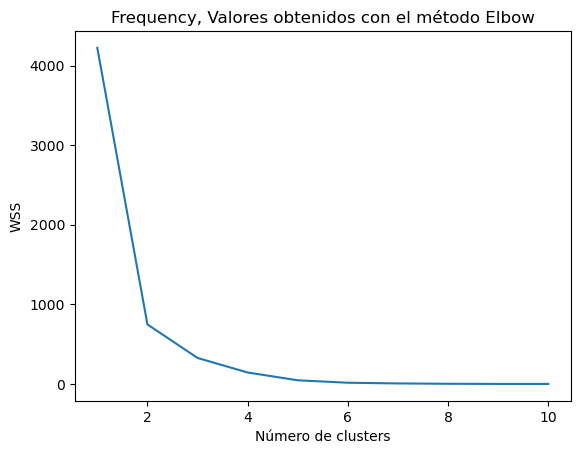

In [83]:
wcss = []  # creamos una lista para almacenar los valores que nos devuelva el modelo con cada grupo de nodos
for i in range(1,11):  # probamos el modelo con con un nodo y vamos aumentando hasta 10 nodos
    kmeans = KMeans(n_clusters=i, random_state= 0)  
    kmeans.fit(df_RFM[['Frequency']])  
    wcss.append(kmeans.inertia_)  

plt.plot(range(1, 11), wcss)  
plt.title('Frequency, Valores obtenidos con el método Elbow')  
plt.xlabel('Número de clusters')  
plt.ylabel('WSS');

In [84]:
Frequency_cluster = KMeans(n_clusters=3, random_state=0)
Frequency_cluster.fit(df_RFM[['Frequency']])

KMeans(n_clusters=3, random_state=0)

In [85]:
Frequency_pred = Frequency_cluster.fit_predict(df_RFM[['Frequency']])
df_RFM['Frequency_cluster'] = Frequency_pred

In [86]:
df_RFM.groupby('Frequency_cluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
Frequency_cluster,,,,,,,,
0,92096.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,2651.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,236.0,3.394068,1.178444,3.0,3.0,3.0,3.0,16.0


Los clusteres de Frequency engloban los siguientes grupos: una compra, dos compras y tres compras o más.

#### Clusterización Monetary.

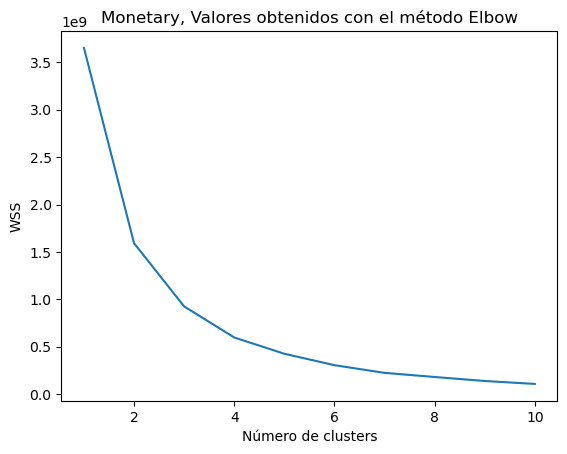

In [87]:
wcss = []  # creamos una lista para almacenar los valores que nos devuelva el modelo con cada grupo de nodos
for i in range(1,11):  # probamos el modelo con con un nodo y vamos aumentando hasta 10 nodos
    kmeans = KMeans(n_clusters=i, random_state= 0)  
    kmeans.fit(df_RFM[['Monetary']])  
    wcss.append(kmeans.inertia_)  

plt.plot(range(1, 11), wcss)  
plt.title('Monetary, Valores obtenidos con el método Elbow')
plt.xlabel('Número de clusters')  
plt.ylabel('WSS');

In [88]:
Monetary_cluster = KMeans(n_clusters=3, random_state=0)
Monetary_cluster.fit(df_RFM[['Monetary']])

KMeans(n_clusters=3, random_state=0)

In [89]:
Monetary_pred = Monetary_cluster.fit_predict(df_RFM[['Monetary']])
df_RFM['Monetary_cluster'] = Monetary_pred

In [90]:
df_RFM.groupby('Monetary_cluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
Monetary_cluster,,,,,,,,
0,86616.0,87.417058,59.529216,0.85,39.90,69.99,120.0,274.00
1,791.0,1611.826726,681.871008,1038.00,1199.90,1389.90,1843.9,7388.00
2,7576.0,461.402912,182.203477,274.49,320.87,389.90,569.0,1035.09


In [91]:
df_RFM['Monetary_cluster_ord'] = df_RFM['Monetary_cluster'].map({0:0, 1:2, 2:1})

In [92]:
df_RFM.groupby('Monetary_cluster_ord')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
Monetary_cluster_ord,,,,,,,,
0,86616.0,87.417058,59.529216,0.85,39.90,69.99,120.0,274.00
1,7576.0,461.402912,182.203477,274.49,320.87,389.90,569.0,1035.09
2,791.0,1611.826726,681.871008,1038.00,1199.90,1389.90,1843.9,7388.00


Los clusteres de Recency engloban los siguientes grupos: compras desde 0,85R$ a 274$R, desde 275R$ a 1035R$ y desde 1038R$ a 7388R$.

In [93]:
df_RFM = df_RFM.drop('Monetary_cluster', axis=1)

#### Clusterización clientes.

Agrupamos a los clientes en función del valor da cada cluster; los clústeres tienen valos ascendentes en función de la importancia de los datos que contienen para maximizar las ventas y los ingresos.

In [94]:
df_RFM['Customer_cluster'] = df_RFM['Recency_cluster_ord'] + df_RFM['Frequency_cluster'] + df_RFM['Monetary_cluster_ord']

In [95]:
df_RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,Recency_cluster_ord,Frequency_cluster,Monetary_cluster_ord,Customer_cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1.0,129.90,2,0,0,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1.0,18.90,2,0,0,2
2,0000f46a3911fa3c0805444483337064,542,1.0,69.00,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1.0,25.99,1,0,0,1
4,0004aac84e0df4da2b147fca70cf8255,293,1.0,180.00,1,0,0,1


In [96]:
df_RFM['Customer_cluster'].unique()

array([2, 0, 1, 3, 4, 5, 6], dtype=int64)

Tenemos seis clusters de clientes.

In [97]:
df_RFM.groupby('Customer_cluster')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
Customer_cluster,,,
0,462.767733,1.000000,85.013837
1,272.556595,1.012314,105.412120
2,111.113204,1.027195,124.545751
3,115.914547,1.289674,461.242429
4,105.854518,1.702910,1020.434395
5,95.708861,3.531646,646.417215
6,64.400000,3.800000,1385.268000


La distribución de los clientes por clústeres esta bastante equilibrada.

Dividimos los clusteres en tres grupos en función del valor que los clústeres le han dado a cada cliente.

In [98]:
df_RFM['Value'] = 'Low'
df_RFM.loc[df_RFM['Customer_cluster']>1,'Value'] = 'Mid' 
df_RFM.loc[df_RFM['Customer_cluster']>4,'Value'] = 'High' 

In [99]:
df_RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,Recency_cluster_ord,Frequency_cluster,Monetary_cluster_ord,Customer_cluster,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1.0,129.90,2,0,0,2,Mid
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1.0,18.90,2,0,0,2,Mid
2,0000f46a3911fa3c0805444483337064,542,1.0,69.00,0,0,0,0,Low
3,0000f6ccb0745a6a4b88665a16c9f078,326,1.0,25.99,1,0,0,1,Low
4,0004aac84e0df4da2b147fca70cf8255,293,1.0,180.00,1,0,0,1,Low


In [100]:
df_RFM.groupby('Customer_cluster').Value.count()

Customer_cluster
0    19977
1    34190
2    36147
3     3932
4      653
5       79
6        5
Name: Value, dtype: int64

In [101]:
df_RFM.groupby('Value').Customer_cluster.count()

Value
High       84
Low     54167
Mid     40732
Name: Customer_cluster, dtype: int64

#### La segmentación de clientes nos da como resultado que sólo 84 clientes tienen un valor alto, no llega a un 1 cliente por cada mil. Un 43% tiene un valor medio y el resto un valor bajo.

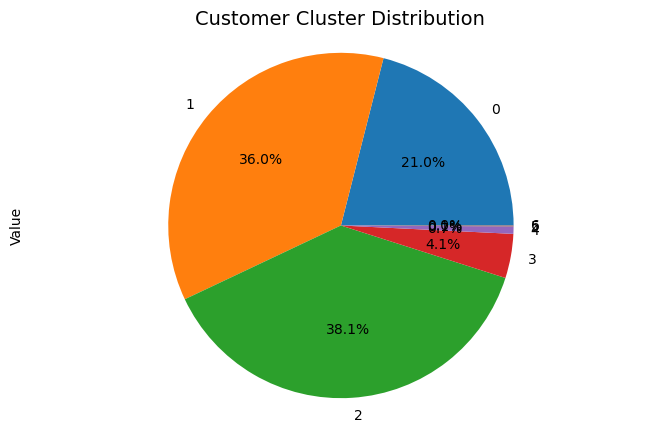

In [102]:
# Visualize the distribution of customers by cluster.
plt.figure(figsize=(8,5))
# df_RFM.Value.value_counts().plot(kind='pie',autopct='%1.0f%%')
df_RFM.groupby('Customer_cluster').Value.count().plot(kind='pie',autopct='%0.01f%%')
plt.axis('equal')
plt.title('Customer Cluster Distribution', fontsize='14')
plt.savefig('CustClusterDist.png')

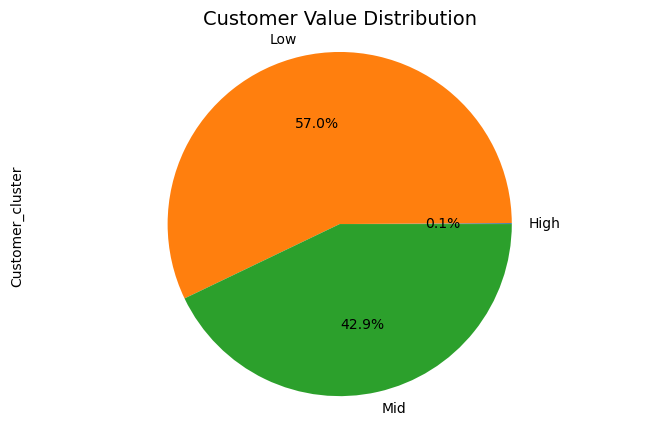

In [103]:
# Visualize the distribution of customers by value.
plt.figure(figsize=(8,5))
# df_RFM.Value.value_counts().plot(kind='pie',autopct='%1.0f%%')
df_RFM.groupby('Value').Customer_cluster.count().plot(kind='pie',autopct='%0.01f%%')
plt.axis('equal')
plt.title('Customer Value Distribution', fontsize='14')
plt.savefig('CustValueDist.png')

## Valor de la vida de un cliente, CLV (Customer Lifetime Value).<a name="id5"></a>

### Modelo BG/NBD.

#### Creación del dataset RFT.
Para el cálculo del Valor de la vida de un cliente necesitamos tres datos, parecidos a los anteriores, pero no iguales:  
- Actualidad o Recency, R, la edad del cliente en el momento de su última compra, corresponde a los días entre su primera y su última compra,
- Frecuencia o Frequency, F, número de periodos en los que un cliente ha repetido una compra,
- Edad o Age, T, la edad del cliente en el momento del estudio, corresponde a los días entre su primera compra y el día del estudio.

La librería Lifetimes tiene una función para crear este dataset automáticamente.

In [104]:
from lifetimes.utils import summary_data_from_transaction_data

In [105]:
df_orders_items_customers_1.head()

,order_id,order_item_id,price,customer_unique_id,order_purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,29.99,7c396fd4830fd04220f754e42b4e5bff,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,118.70,af07308b275d755c9edb36a90c618231,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,159.90,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,45.00,7c142cf63193a1473d2e66489a9ae977,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,19.90,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13


Fecha final de recogida de datos. Tomamos esta fecha como fecha del estudio.

In [106]:
df_orders_items_customers_1.order_purchase_date.max()

Timestamp('2018-09-03 00:00:00')

In [107]:
df_CLV = df_orders_items_customers_1.groupby(['customer_unique_id','order_purchase_date']).price.sum().reset_index()

In [108]:
df_CLV

,customer_unique_id,order_purchase_date,price
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-10,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,180.00
...,...,...,...
97264,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,890.00
97265,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,64.89
97266,ffff371b4d645b6ecea244b27531430a,2017-02-07,89.90
97267,ffff5962728ec6157033ef9805bacc48,2018-05-02,115.00


Este es el dataset con el que calcularemos el CLV.

In [109]:
data = summary_data_from_transaction_data(df_CLV, 'customer_unique_id', 'order_purchase_date', observation_period_end='2018-09-03')

In [110]:
data.head()

,frequency,recency,T
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0


In [111]:
data.shape

(94983, 3)

In [112]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 94983 subjects, a: 2.06, alpha: 65.93, b: 0.35, r: 0.02>


In [113]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.015553,0.000821,0.013944,0.017163
alpha,65.929520,6.243937,53.691404,78.167636
a,2.059440,0.492537,1.094067,3.024812
b,0.351330,0.092023,0.170965,0.531696


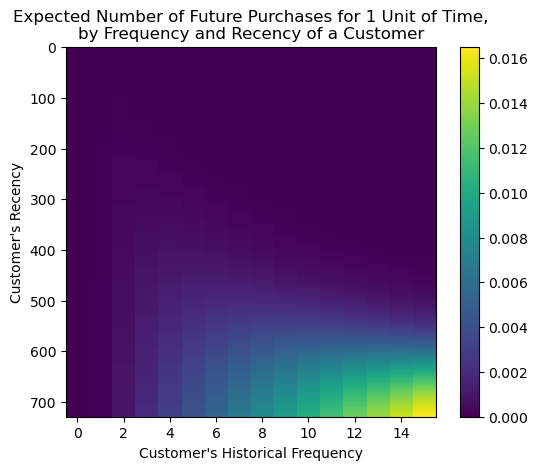

In [114]:
plot_frequency_recency_matrix(bgf);
plt.savefig('FreqRecMatrix.png')

Los clientes con el mejor valor se sitúan en la zona amarilla, donde el Recency es mayor, lo que sinifica que el cliente ha vuelto a comprar entre 600 y 700 días despuñes de hacer su primera compra; y que la frecuencia de estas compras es superior a 10 compras.

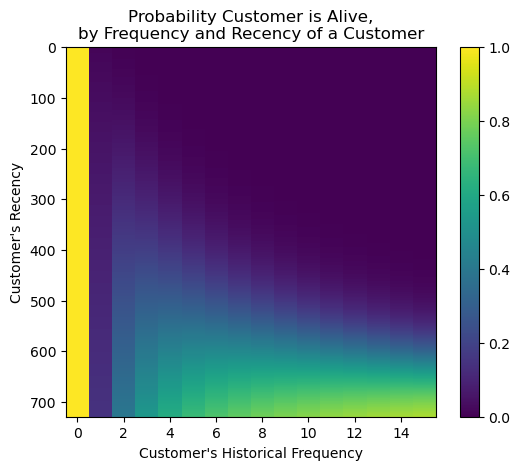

In [115]:
plot_probability_alive_matrix(bgf);
plt.savefig('FreqRecAlive.png')

Los clientes con más probabilidades de estar activos se sitúan en la zona verde-amarilla de la matriz, las compras son frecuentes y lleva tiempo en el marketplace. Los clientes que aún no han hecho una compra se les considera vivos.

En este dataset tanto el valor de los clientes como su retención son muy bajos.

#### Predicción de ventas por cliente para un periodo de tiempo de un día y de un mes.

Prección de las ventas por cliente para el periodo de un día.

In [116]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
customer_unique_id,,,,
e0836a97eaae86ac4adc26fbb334a527,2.0,62.0,69.0,0.005510
6469f99c1f9dfae7733b25662e7f1782,5.0,282.0,349.0,0.005624
dc813062e0fc23409cd255f7f53c7074,5.0,418.0,429.0,0.006613
394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,255.0,0.006991
8d50f5eadf50201ccdcedfb9e2ac8455,15.0,462.0,476.0,0.022810


Este resultado nos hace ver que la probabilidad de que un cliente compre a diaro es bajísima, no llegado en a 7 por mil en los mejores clientes.

Prección de las ventas por cliente para el periodo de un mes.

In [117]:
t = 30
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
customer_unique_id,,,,
ca77025e7201e3b30c44b472ff346268,6.0,235.0,329.0,0.144223
6469f99c1f9dfae7733b25662e7f1782,5.0,282.0,349.0,0.159448
dc813062e0fc23409cd255f7f53c7074,5.0,418.0,429.0,0.189158
394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,255.0,0.195571
8d50f5eadf50201ccdcedfb9e2ac8455,15.0,462.0,476.0,0.651337


Vemos que los cinco clientes que más compran harían entre 0,14 y 0,65 ventas en un mes.

La predicción de una compra mensual tampoco se cumple en ningún caso.

#### Predicción de la frecuencia en la repetición de las compras.

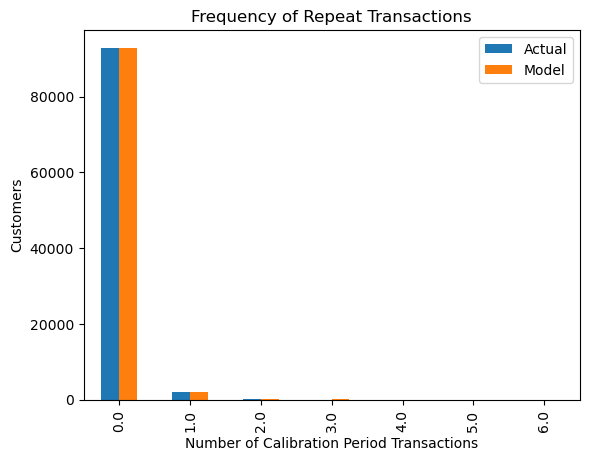

In [118]:
plot_period_transactions(bgf);
plt.savefig('FreqRepeatTrans.png')

La alta mayoría de los clientes compran sólo una vez.

 #### Creamos el modelo.

Train-test split.

In [119]:
summary_cal_holdout = calibration_and_holdout_data(df_CLV, 'customer_unique_id', 'order_purchase_date',
                                        calibration_period_end='2018-05-01',
                                        observation_period_end='2018-09-03' ,
                                        monetary_value_col = 'price')

In [120]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,0.0,0.0,417.0,0.0,0.0,0.0,125.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,201.0,0.0,0.0,0.0,125.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,168.0,0.0,0.0,0.0,125.0
0004bd2a26a76fe21f786e4fbd80607f,0.0,0.0,26.0,0.0,0.0,0.0,125.0
00050ab1314c0e55a6ca13cf7181fecf,0.0,0.0,11.0,0.0,0.0,0.0,125.0
...,...,...,...,...,...,...,...
fffcc512b7dfecaffd80f13614af1d16,0.0,0.0,20.0,0.0,0.0,0.0,125.0
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,327.0,0.0,0.0,0.0,125.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,142.0,0.0,0.0,0.0,125.0


In [121]:
summary_cal_holdout = summary_cal_holdout[summary_cal_holdout['monetary_value_cal']>0]

In [122]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_unique_id,,,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,278.0,87.900,0.0,0.00,125.0
011575986092c30523ecb71ff10cb473,1.0,60.0,73.0,63.900,0.0,0.00,125.0
011b4adcd54683b480c4d841250a987f,1.0,177.0,252.0,56.970,0.0,0.00,125.0
013f4353d26bb05dc6652f1269458d8d,1.0,4.0,158.0,64.000,0.0,0.00,125.0
015557c9912277312b9073947804a7ba,1.0,39.0,404.0,59.900,0.0,0.00,125.0
...,...,...,...,...,...,...,...
fe59d5878cd80080edbd29b5a0a4e1cf,2.0,76.0,328.0,24.490,0.0,0.00,125.0
fe81bb32c243a86b2f86fbf053fe6140,2.0,124.0,191.0,63.550,2.0,676.15,125.0
fed519569d16e690df6f89cb99d4e682,1.0,88.0,132.0,89.900,0.0,0.00,125.0


Entrenamiento del modelo.

#### Modelo BetaGeoFitter, predice las compras y la tasa de abandono.

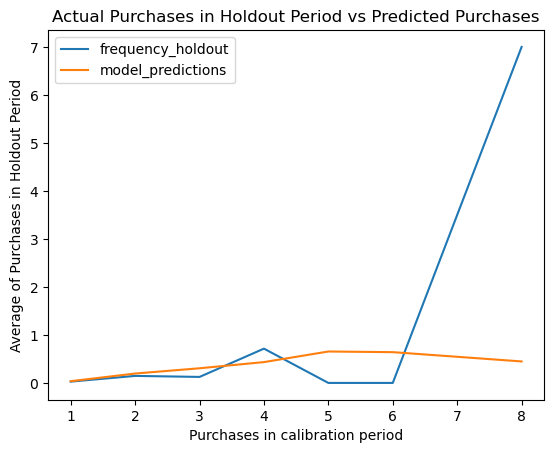

In [123]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);
plt.savefig('PurchHoldoutPred.png')

La predicción del modelo es buena para una compra y para dos, empeora en la tercera compra y a partir de aquí va aumentando el error con cada compra añadida. Es un comportamiento esperable debido a la falta de muestras de clientes recurrentes.

In [124]:
predicted_bgf = bgf.predict((dt.datetime(2018,8,30)- dt.datetime(2018,5,31)).days,
                        summary_cal_holdout['frequency_cal'], 
                        summary_cal_holdout['recency_cal'], 
                        summary_cal_holdout['T_cal'])

In [125]:
actual = summary_cal_holdout['frequency_holdout']
predicted = predicted_bgf
print(f"Average absolute error: {mean_absolute_error(actual, predicted)}")

Average absolute error: 0.07702627093537226


La media del error absoluto es 7,7%.

#### Predicción de las ventas para un cliente concreto.

In [126]:
t = 24 #predict purchases in 24 periods
individual = data.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.22907523006330824

El cliente con el registro número 20 hará 0,22 compras en los próximos 24 días.

#### Cálculo de la probabilidad de retención de un cliente a lo largo del tiempo.

In [127]:
from lifetimes.plotting import plot_history_alive

id = 'dc813062e0fc23409cd255f7f53c7074'
days_since_birth = int(data['T'][id])
sp_trans = df_CLV.loc[df_CLV['customer_unique_id'] == id]

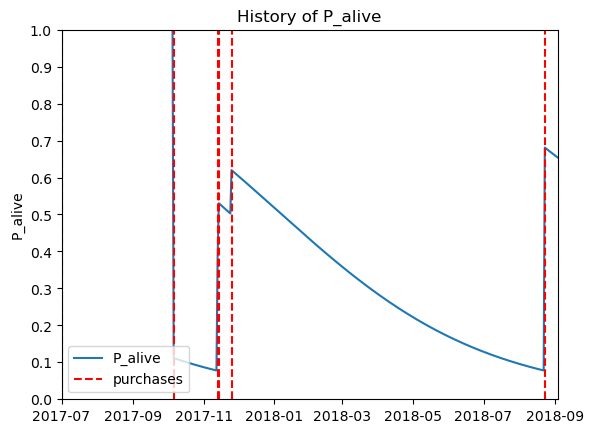

In [128]:
plot_history_alive(bgf, days_since_birth, sp_trans, 'order_purchase_date');
plt.savefig('HistP-alive.png')

Observamos que la probabilidad de que un cliente se mantenga activo y fiel a la marca aumneta con cada compra y disminuye drásticamente en los periodos entre compra y compra.

In [129]:
summary_cal_holdout[['monetary_value_cal', 'frequency_cal']].corr()

,monetary_value_cal,frequency_cal
monetary_value_cal,1.00000,-0.03053
frequency_cal,-0.03053,1.00000


No hay correlación entre las variables.

#### Modelo Gamma-Gamma, predice la ganancia promedio de cada cliente.

In [130]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['monetary_value_cal'])

<lifetimes.GammaGammaFitter: fitted with 1345 subjects, p: 2.76, q: 3.16, v: 85.55>

In [131]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['monetary_value_cal']
    ).mean(),
    summary_cal_holdout[summary_cal_holdout['frequency_cal']>0]['monetary_value_cal'].mean()
))

Expected conditional average profit: 109.68394520624331, Average profit: 110.06913729863692


La media de las ganancias por cliente es de 109,68 reales brasileños, y el modelo predice 110,07 reales brasileños.

#### Ambos modelos se combinan para obtener el CLV en un periodo de 30 días.

In [132]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

summary_cal_holdout['CLV_30'] = ggf.customer_lifetime_value(
    bgf, # modelo que predice futuras compras
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal'],
    summary_cal_holdout['monetary_value_cal'],
    time=30, # días
)

In [133]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,CLV_30
customer_unique_id,,,,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,278.0,87.900,0.0,0.00,125.0,7.001486
011575986092c30523ecb71ff10cb473,1.0,60.0,73.0,63.900,0.0,0.00,125.0,15.109068
011b4adcd54683b480c4d841250a987f,1.0,177.0,252.0,56.970,0.0,0.00,125.0,7.896162
013f4353d26bb05dc6652f1269458d8d,1.0,4.0,158.0,64.000,0.0,0.00,125.0,3.578330
015557c9912277312b9073947804a7ba,1.0,39.0,404.0,59.900,0.0,0.00,125.0,0.412472
...,...,...,...,...,...,...,...,...
fe59d5878cd80080edbd29b5a0a4e1cf,2.0,76.0,328.0,24.490,0.0,0.00,125.0,4.626523
fe81bb32c243a86b2f86fbf053fe6140,2.0,124.0,191.0,63.550,2.0,676.15,125.0,42.307344
fed519569d16e690df6f89cb99d4e682,1.0,88.0,132.0,89.900,0.0,0.00,125.0,13.082990


In [134]:
summary_cal_holdout.CLV_30.describe()

count    1345.000000
mean       11.583881
std        20.806208
min         0.041907
25%         2.274482
50%         5.922846
75%        12.730320
max       277.216672
Name: CLV_30, dtype: float64

El modelo prevee que un cliente generará en 30 días una media de 11,58 reales brasileños. El 50% de los clientes generarán un valor de por debajo de los 6 reales brasileños, un 25% por debajo de los 12,73 y del otro 25% el valor máximo sería de 277,21 reales brasileños.

#### Ambos modelos se combinan para obtener el CLV en un periodo de 90 días.

In [135]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

summary_cal_holdout['CLV_90'] = ggf.customer_lifetime_value(
    bgf, # modelo que predice futuras compras
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal'],
    summary_cal_holdout['monetary_value_cal'],
    time=90, # días
)

In [136]:
summary_cal_holdout.CLV_90.describe()

count    1345.000000
mean       12.684199
std        24.123704
min         0.044983
25%         2.431922
50%         6.310437
75%        13.566919
max       337.148358
Name: CLV_90, dtype: float64

El valor generado en 90 días sigue un distribución y tiene un valor muy parecido, sólo cambia la cantidad máxima que es de 377,15 reales brasileños.

#### Ahora que tenemos el CLV de cada cliente a 90 días podemos segmentar a los clientes en función de valor futuro.

In [137]:
summary_cal_holdout['segment'] = pd.qcut(summary_cal_holdout['CLV_90'],4,['D','C','B','A'])

summary_cal_holdout

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,CLV_30,CLV_90,segment
customer_unique_id,,,,,,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,278.0,87.900,0.0,0.00,125.0,7.001486,7.478526,B
011575986092c30523ecb71ff10cb473,1.0,60.0,73.0,63.900,0.0,0.00,125.0,15.109068,16.083676,A
011b4adcd54683b480c4d841250a987f,1.0,177.0,252.0,56.970,0.0,0.00,125.0,7.896162,8.430511,B
013f4353d26bb05dc6652f1269458d8d,1.0,4.0,158.0,64.000,0.0,0.00,125.0,3.578330,3.814519,C
015557c9912277312b9073947804a7ba,1.0,39.0,404.0,59.900,0.0,0.00,125.0,0.412472,0.441502,D
...,...,...,...,...,...,...,...,...,...,...
fe59d5878cd80080edbd29b5a0a4e1cf,2.0,76.0,328.0,24.490,0.0,0.00,125.0,4.626523,5.157658,C
fe81bb32c243a86b2f86fbf053fe6140,2.0,124.0,191.0,63.550,2.0,676.15,125.0,42.307344,47.005471,A
fed519569d16e690df6f89cb99d4e682,1.0,88.0,132.0,89.900,0.0,0.00,125.0,13.082990,13.940526,A


In [138]:
summary_cal_holdout.groupby('segment').describe()

frequency_cal                                               \
                count      mean       std  min  25%  50%  75%  max   
segment                                                              
D               337.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
C               336.0  1.011905  0.108619  1.0  1.0  1.0  1.0  2.0   
B               336.0  1.023810  0.152683  1.0  1.0  1.0  1.0  2.0   
A               336.0  1.377976  0.815882  1.0  1.0  1.0  2.0  8.0   

        recency_cal              ...     CLV_30             CLV_90             \
              count        mean  ...        75%         max  count       mean   
segment                          ...                                            
D             337.0   52.284866  ...   1.673324    2.274482  337.0   1.216986   
C             336.0   96.383929  ...   4.790302    5.922846  336.0   4.152319   
B             336.0  120.119048  ...  10.502462   12.732153  336.0   9.615626   
A             336.0  136.648810  ...  33.691531  277.216672  336.0  35.785995   

                                                                            
               std        min        25%        50%        75%         max  
segment                                                                     
D         0.668277   0.044983   0.616059   1.204662   1.788656    2.431922  
C         1.107035   2.433339   3.136286   4.111576   5.121518    6.310437  
B         2.032481   6.332280   7.891985   9.486930  11.196321   13.566919  
A        39.735802  13.621367  17.129261  21.893258  36.929053  337.148358  

[4 rows x 72 columns]

La segmentacion refleja que el mejor grupo es el A, estos clientes tienen la vida en la plataforma más larga (Recency), con una media de 136 días, la mayor frecuencia de compra, hasta 8 compras, el mayor valor por cliente a los 90 días y la tasa de abandono más baja.

In [139]:
bgf.save_model('bgf.pkl')

## Predicción de tasa de abandono (Churn Prediction).<a name="id6"></a>

In [140]:
summary_cal_holdout['Churn'] = 1-bgf.conditional_probability_alive(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

In [141]:
summary_cal_holdout.sort_values('Churn')

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,CLV_30,CLV_90,segment,Churn
customer_unique_id,,,,,,,,,,,
f0e310a6839dce9de1638e0fe5ab282a,5.0,320.0,346.0,42.218000,0.0,0.00,125.0,113.035410,138.095768,A,0.384580
ca77025e7201e3b30c44b472ff346268,4.0,199.0,204.0,77.695000,2.0,42.99,125.0,163.724912,193.948316,A,0.393273
1b6c7548a2a1f9037c1fd3ddfed95f33,6.0,93.0,169.0,97.831667,0.0,0.00,125.0,204.332286,253.583440,A,0.482683
3e43e6105506432c953e165fb2acf44c,5.0,162.0,225.0,156.650000,0.0,0.00,125.0,277.216672,337.148358,A,0.490525
56c8638e7c058b98aae6d74d2dd6ea23,3.0,281.0,293.0,111.426667,0.0,0.00,125.0,156.129160,180.074971,A,0.501720
...,...,...,...,...,...,...,...,...,...,...,...
a7bbfaf8a288c45dc38d4693535dd63f,1.0,9.0,457.0,29.900000,0.0,0.00,125.0,0.139415,0.149359,D,0.998806
325e19085f3017b73be3d9fd98a93301,1.0,12.0,467.0,49.000000,0.0,0.00,125.0,0.152105,0.162982,D,0.998882
a5d3bfee5b23b430b95c4ae295e1028a,1.0,2.0,465.0,9.900000,0.0,0.00,125.0,0.098642,0.105692,D,0.998978


In [142]:
summary_cal_holdout.Churn.describe()

count    1345.000000
mean        0.946122
std         0.070549
min         0.384580
25%         0.929121
50%         0.964973
75%         0.986714
max         0.999643
Name: Churn, dtype: float64

Esta métrica nos confirma que en este dataset no hay clientes recurrentes, la tasa de abandono es de un 94% de media.

## Predicción de ventas (Sales forecasting).<a name="id7"></a>

In [143]:
df_orders_items_customers_1

,order_id,order_item_id,price,customer_unique_id,order_purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,29.99,7c396fd4830fd04220f754e42b4e5bff,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,118.70,af07308b275d755c9edb36a90c618231,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,159.90,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,45.00,7c142cf63193a1473d2e66489a9ae977,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,19.90,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13
...,...,...,...,...,...
98194,9c5dedf39a927c1b2549525ed64a053c,1.0,72.00,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09
98195,63943bddc261676b46f01ca7ac2f7bd8,1.0,174.90,da62f9e57a76d978d02ab5362c509660,2018-02-06
98196,83c1379a015df1e13d02aae0204711ab,1.0,205.99,737520a9aad80b3fbbdad19b66b37b30,2017-08-27
98197,11c177c8e97725db2631073c19f07b62,1.0,179.99,5097a5312c8b157bb7be58ae360ef43c,2018-01-08


Antes de empezar a trabajar con Prophet debemos preparar el dataset con unas características concretas.

In [144]:
df_date = df_orders_items_customers_1.drop(['order_id', 'order_item_id', 'customer_unique_id'], axis=1)
df_date.rename(columns={'order_purchase_date':'ds', 'price':'y'}, inplace=True)

In [145]:
df_date

,y,ds
0,29.99,2017-10-02
1,118.70,2018-07-24
2,159.90,2018-08-08
3,45.00,2017-11-18
4,19.90,2018-02-13
...,...,...
98194,72.00,2017-03-09
98195,174.90,2018-02-06
98196,205.99,2017-08-27
98197,179.99,2018-01-08


In [146]:
df_date = df_date.groupby('ds').y.sum().reset_index()

In [147]:
df_date.head()

,ds,y
0,2016-09-04,39.99
1,2016-09-15,44.99
2,2016-10-03,441.98
3,2016-10-04,8933.06
4,2016-10-05,5902.92


Dividimos el dataset en train y test.

In [148]:
df_train = df_date.loc[df_date.index<0.8*df_date.shape[0]].reset_index(drop=True)

In [149]:
df_test = df_date.loc[df_date.index>0.8*df_date.shape[0]].reset_index(drop=True)

### Modelo Prophet.

In [150]:
p = Prophet(interval_width=0.85, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,changepoint_range=0.9)

Entrenamos el modelo.

In [151]:
model = p.fit(df_train)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


          ds          yhat    yhat_lower    yhat_upper
0 2018-05-01  33537.122662  24776.780749  41794.521809
1 2018-05-02  33208.414121  25308.159204  42561.043764
2 2018-05-03  32050.956421  22605.804061  40861.532071
3 2018-05-04  32403.241190  23720.642594  41391.720882
4 2018-05-05  28174.980321  18973.890046  37256.440845


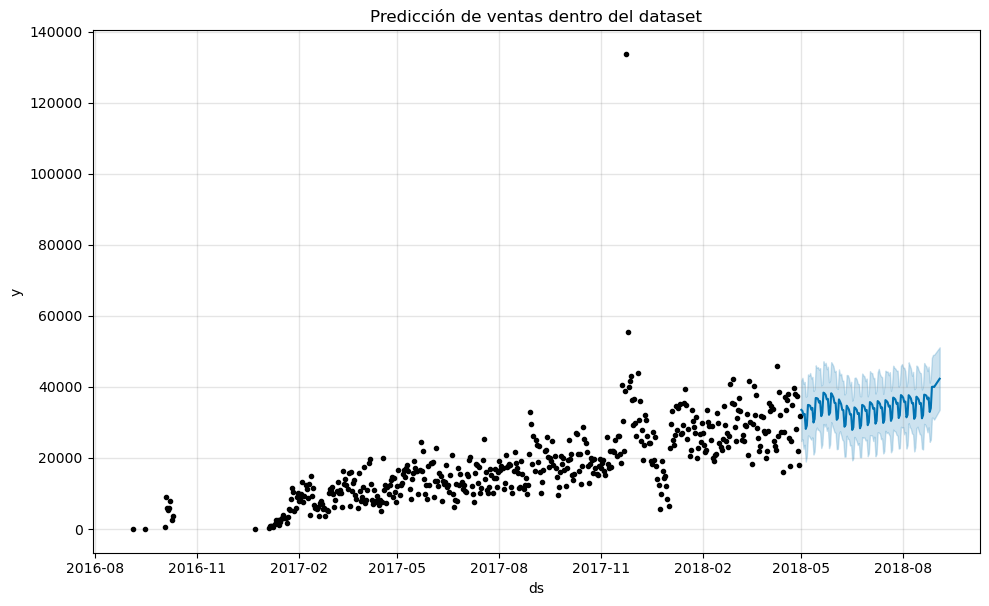

In [152]:
forecast = model.predict(df_test)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()) 
model.plot(forecast)
plt.title('Predicción de ventas dentro del dataset')
plt.savefig('ForecTrainTest.png')

Cálculo del error medio absoluto.

MAE: 9623.249


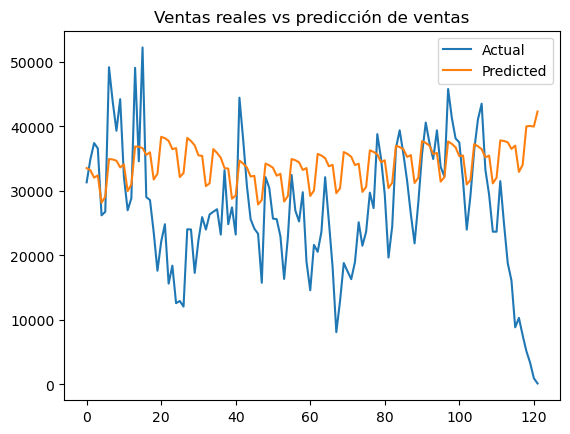

In [153]:
y_true = df_test['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Ventas reales vs predicción de ventas')
plt.legend()
plt.savefig('ActPredValues.png')

El MAE es 8078.831, el modelo no ajusta bien por defecto. Deberemos incluir la tendencia y la estacioalidad.

In [154]:
df_date.sort_values('ds')

,ds,y
0,2016-09-04,39.99
1,2016-09-15,44.99
2,2016-10-03,441.98
3,2016-10-04,8933.06
4,2016-10-05,5902.92
...,...,...
609,2018-08-26,7622.73
610,2018-08-27,5162.92
611,2018-08-28,3377.33
612,2018-08-29,970.84


#### Predicción de ventas en el periodo de 120 días.

In [155]:
p = Prophet(interval_width=0.85, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,changepoint_range=0.9)

In [156]:
model = p.fit(df_date)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Primero debemos hacer un dataset que pueda contener los datos de la predicción cuando la hagamos.

In [157]:
pred_sales = p.make_future_dataframe(periods=120, freq='D')
pred_sales.tail()

,ds
729,2018-12-28
730,2018-12-29
731,2018-12-30
732,2018-12-31
733,2019-01-01


Hacemos la predición.

In [158]:
forecast_prediction = p.predict(pred_sales)
forecast_prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
729,2018-12-28,25917.893788,7930.743656,26293.066078,25067.165028,26751.654088,-9018.288208,-9018.288208,-9018.288208,498.693195,...,178.970052,178.970052,178.970052,-9695.951455,-9695.951455,-9695.951455,0.0,0.0,0.0,16899.605579
730,2018-12-29,25911.785523,3523.847473,22823.716281,25042.154989,26750.870261,-12929.576118,-12929.576118,-12929.576118,498.693195,...,-4263.355996,-4263.355996,-4263.355996,-9164.913317,-9164.913317,-9164.913317,0.0,0.0,0.0,12982.209405
731,2018-12-30,25905.677258,4359.282314,23295.605117,25017.273322,26751.783256,-11445.342420,-11445.342420,-11445.342420,498.693195,...,-3397.297451,-3397.297451,-3397.297451,-8546.738164,-8546.738164,-8546.738164,0.0,0.0,0.0,14460.334838
732,2018-12-31,25899.568993,12157.623177,31242.527278,24996.820666,26753.574051,-4711.637764,-4711.637764,-4711.637764,498.693195,...,2648.050572,2648.050572,2648.050572,-7858.381531,-7858.381531,-7858.381531,0.0,0.0,0.0,21187.931229
733,2019-01-01,25893.460728,11604.716391,30557.019211,24972.406701,26759.392260,-4303.831449,-4303.831449,-4303.831449,498.693195,...,2314.624780,2314.624780,2314.624780,-7117.149424,-7117.149424,-7117.149424,0.0,0.0,0.0,21589.629278


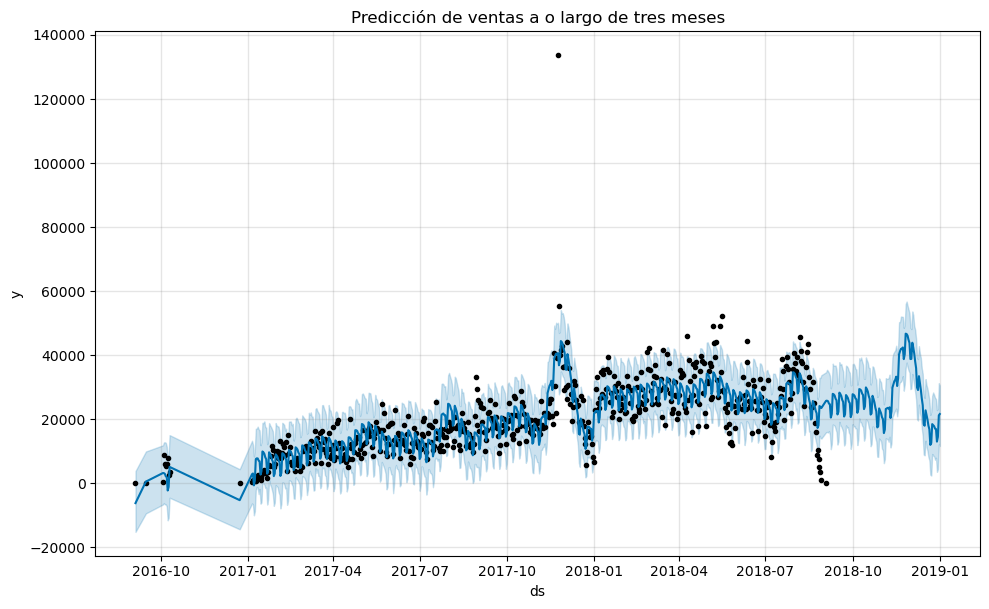

In [159]:
graf_pred120 = p.plot(forecast_prediction)
plt.title('Predicción de ventas a o largo de tres meses')
plt.savefig('ForecPred120.png')

El modelo ajusta mejor en la predicción de estos tres meses al tener las muestras del dataset entero en las que basarse.

Prophet permite marcar los días relevantes del dataset de series temporales univariantes.

Text(0.5, 1.0, 'Predicción de ventas con puntos relevantes')

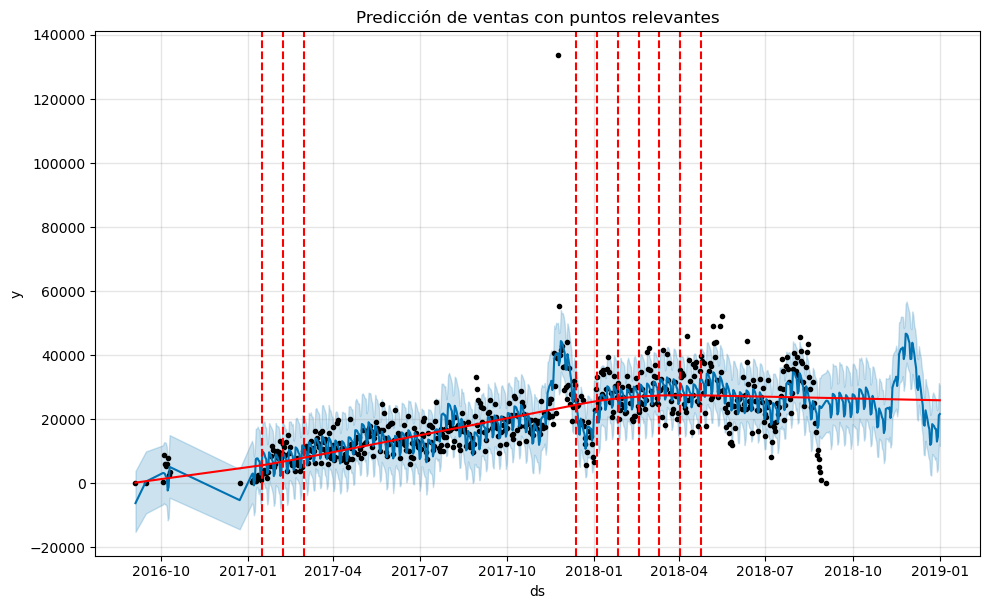

In [160]:
from prophet.plot import add_changepoints_to_plot
graf_pred120 = p.plot(forecast_prediction)  # predicción
a = add_changepoints_to_plot(graf_pred120.gca(), p, forecast_prediction)  # días relevantes que se añaden al plot
plt.title('Predicción de ventas con puntos relevantes')

Descomposicón de la predicción. Al ser Prophet un modelo de agregación podemos descomponerlo en diferentes métrica, tendencia, distribucíon semanal, anual y diaria.

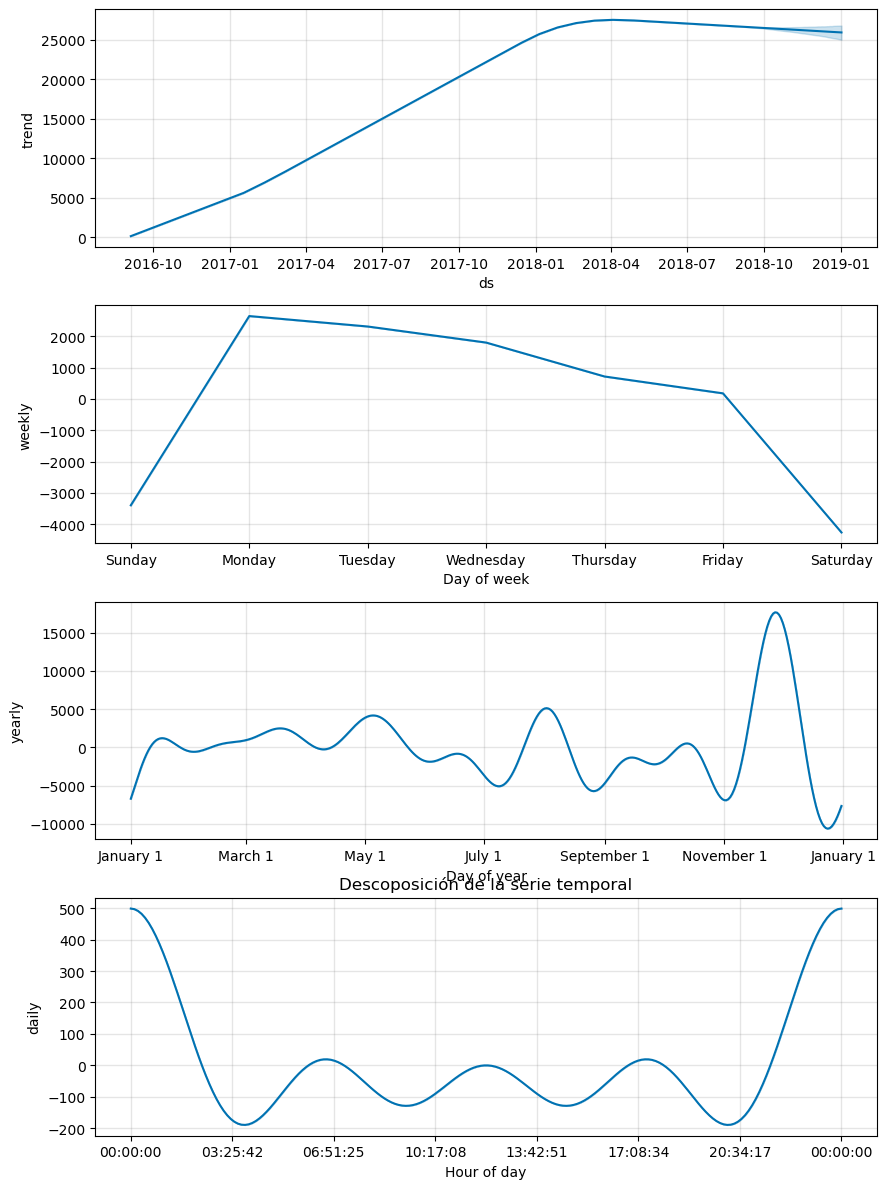

In [161]:
graf_pred120comp = p.plot_components(forecast_prediction)
plt.title('Descoposición de la serie temporal')
plt.savefig('ForecPredComponents.png')

Observamos que la serie temporal tiene dos tendencias diferenciadas, una ascendente y otra plana.  
Con la distribución anual podemos ver los eventos que más influyen en las ventas, como el Black Friday en noviembre.  
Durante la semana vemos que se compra algo el lunes, pero las compras se reparten entre lunes y viernes y caen los fines de semana.  
Durante el día vemos una clara tendencia a hacer las compras por la noche.  
Con estos datos podremos ajustar mejor el modelo en la siguiente previsión.

In [162]:
plt.close()

Guardamos el modelo.

In [163]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(p))